## Tracking and trajectory estimation

In [110]:
from functools import lru_cache

import numpy as np
from scipy.optimize import linear_sum_assignment
import pandas as pd

### Load sample data

In [111]:
base_path = "../drone-yolov7-dataset/valid"

In [27]:
df = pd.read_csv(f"{base_path}/converted_labels/processed_data.csv")

In [29]:
def convert_bbox_format(df):
    # Calculate the corner coordinates
    df['x1'] = (df['x_center'] - df['width'] / 2)
    df['y1'] = (df['y_center'] - df['height'] / 2)
    df['x2'] = (df['x_center'] + df['width'] / 2)
    df['y2'] = (df['y_center'] + df['height'] / 2)
    
    # Creating a dictionary format for each row if needed
    df['bbox_corners'] = df.apply(lambda row: {"x1": row['x1'], "y1": row['y1'], "x2": row['x2'], "y2": row['y2']}, axis=1)
    return df

# Convert and print new DataFrame
converted_df = convert_bbox_format(df)

In [30]:
converted_df

class_id  x_center  y_center     width    height         image  \
0            0  0.539062  0.449219  0.075000  0.071094  DV (749).jpg   
1            0  0.530469  0.485938  0.432812  0.281250  DV (319).jpg   
2            0  0.517188  0.471094  0.499219  0.124219  DV (175).jpg   
3            0  0.186719  0.364063  0.228906  0.064062  DV (525).jpg   
4            0  0.571875  0.416406  0.536719  0.296875  DV (876).jpg   
...        ...       ...       ...       ...       ...           ...   
1035         0  0.590741  0.428906  0.270370  0.078646  DV (361).jpg   
1036         0  0.508203  0.468750  0.638281  0.404167  DV (674).jpg   
1037         0  0.499740  0.463889  0.394271  0.272222   DV (36).jpg   
1038         0  0.571094  0.503906  0.432812  0.281250  DV (224).jpg   
1039         0  0.421094  0.407031  0.379688  0.457031  DV (418).jpg   

      image_number        x1        y1        x2        y2  \
0              749  0.501563  0.413672  0.576562  0.484766   
1              319  0.314063  0.345313  0.746875  0.626563   
2              175  0.267578  0.408984  0.766797  0.533203   
3              525  0.072266  0.332031  0.301172  0.396094   
4              876  0.303516  0.267969  0.840234  0.564844   
...            ...       ...       ...       ...       ...   
1035           361  0.455556  0.389583  0.725926  0.468229   
1036           674  0.189062  0.266667  0.827344  0.670833   
1037            36  0.302604  0.327778  0.696875  0.600000   
1038           224  0.354687  0.363281  0.787500  0.644531   
1039           418  0.231250  0.178516  0.610938  0.635547   

                                           bbox_corners  
0     {'x1': 0.5015625, 'y1': 0.413671875, 'x2': 0.5...  
1     {'x1': 0.3140625, 'y1': 0.3453125, 'x2': 0.746...  
2     {'x1': 0.267578125, 'y1': 0.40898437499999996,...  
3     {'x1': 0.07226562499999999, 'y1': 0.33203125, ...  
4     {'x1': 0.303515625, 'y1': 0.26796875, 'x2': 0....  
...                                                 ...  
1035  {'x1': 0.45555555625000005, 'y1': 0.3895833328...  
1036  {'x1': 0.18906249999999997, 'y1': 0.2666666671...  
1037  {'x1': 0.30260416718749994, 'y1': 0.3277777781...  
1038  {'x1': 0.35468749999999993, 'y1': 0.36328125, ...  
1039  {'x1': 0.23124999999999998, 'y1': 0.178515625,...  

[1040 rows x 12 columns]

## Tracking

In [166]:
class BoundingBox:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
  
    def __repr__(self):
        return f"BoundingBox(x1={self.x1}, y1={self.y1}, x2={self.x2}, y2={self.y2})"

In [322]:
#@lru_cache(maxsize=None)
def compute_iou(tracklet_a, box_b):
    """
    Intersection over union
    :param box_a: Tracklet
    :param box_b: Dict
    :return: iou
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    x_1 = np.maximum(tracklet_a.x1, box_b['x1'])
    y_1 = np.maximum(tracklet_a.y1, box_b['y1'])
    x_2 = np.minimum(tracklet_a.x2, box_b['x2'])
    y_2 = np.minimum(tracklet_a.y2, box_b['y2'])

    if (x_2 - x_1) < 0 or (y_2 - y_1) < 0:
        return 0.0

    # compute the area of intersection rectangle
    intersection_area = (x_2 - x_1 + 1) * (y_2 - y_1 + 1)

    # compute the area of both box_a and box_b
    tracklet_a_area = (tracklet_a.x2 - tracklet_a.x1) * (tracklet_a.y2 - tracklet_a.y1)
    box_b_area = (box_b['x2'] - box_b['x1']) * (box_b['y2'] - box_b['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(tracklet_a_area + box_b_area - intersection_area)

    # return the intersection over union value
    if iou >= 0.0 and iou <= 1.0:
        return iou
    else:
        return 0.0

In [323]:
def compute_assignment_matrix(tracks, detections):
    # initialize cost matrix
    association_mat = np.zeros((len(tracks), len(detections)))
    # fill cost matix
    for t, track in enumerate(tracks):
        for d, detection in enumerate(detections):
            # TODO memoize this function
            if track and detection:
                iou = compute_iou(track, detection)
            else:
                iou = 0.0
            association_mat[t][d] = iou
    # Solve Hungarian/Munkres algorithm
    return (*linear_sum_assignment(-association_mat), association_mat)

In [324]:
def compute_association(tracks: list, detections: list, iou_threshold=0.3):
    """
    Associates previous tracked detections (tracks) with new detections using the Hungarian algorithm (Munkres).
    The assignment cost in cost-matrix for Munkres is the iou between each track box and the detection box.

    :param tracks: list of previous tracked detections, initially empty
    :param detections: list of new detections
    :return: matches, unmatched trackers, unmatched detections
    """

    matched_tracks, matched_detections, association_mat = compute_assignment_matrix(tracks, detections)

    unmatched_tracks = np.array(list(set(range(len(tracks))).difference(matched_tracks)), dtype=np.int64)
    unmatched_detections = np.array(list(set(range(len(detections))).difference(matched_detections)), dtype=np.int64)

    matches = []

    for match in zip(matched_tracks, matched_detections):
        if association_mat[match[0], match[1]] < iou_threshold:
            unmatched_tracks = np.append(unmatched_tracks, match[0])
            unmatched_detections = np.append(unmatched_detections, match[1])
        else:
            matches.append(np.array(match))

    return matches, unmatched_detections, unmatched_tracks

In [325]:
from collections import deque

from filterpy.kalman import KalmanFilter as KF
import numpy as np

In [367]:
class KalmanFilter:
    def __init__(self, dt=1/24.0):
        self.kf = KF(dim_x=6, dim_z=4)  # 6 state variables, 4 measurements

        # State Transition Matrix for constant velocity model
        self.kf.F = np.eye(6)
        self.kf.F[0, 4] = dt  # x1 velocity influence
        self.kf.F[1, 5] = dt  # y1 velocity influence
        self.kf.F[2, 4] = dt  # x2 velocity influence
        self.kf.F[3, 5] = dt  # y2 velocity influence

        # Measurement function: we only measure positions
        self.kf.H = np.zeros((4, 6))
        self.kf.H[0, 0] = 1  # Measure x1
        self.kf.H[1, 1] = 1  # Measure y1
        self.kf.H[2, 2] = 1  # Measure x2
        self.kf.H[3, 3] = 1  # Measure y2

        # Initial state covariance
        self.kf.P *= 1000  # Start with a large uncertainty

        # Measurement noise covariance
        self.kf.R = np.diag([1, 1, 1, 1])  # Smaller values indicate high confidence in the measurements

        # Process noise covariance
        self.kf.Q = np.eye(6) * 0.1  # Adjust based on movement variability

    def update(self, z):
        """ Update the Kalman Filter from a new measurement """
        self.kf.update(z)

    def predict(self):
        """ Predict the next state of the Kalman Filter """
        self.kf.predict()
        return self.kf.x  # Return the predicted state



In [478]:
class Tracklet:
    def __init__(self, track_id=0):
        self.track_id = track_id
        self.positions = [] 

        vx = 1
        vy = 1

        x1 = 0
        y1 = 0
        x2 = 0
        y2 = 0

        # Create a new Kalman filter instance for this track
        self.kf = KalmanFilter()

        # Set initial state
        initial_state = np.array([x1, y1, x2, y2, vx, vy]).reshape(6, 1)  # Include zero initial velocities

        self.kf.kf.x = initial_state  # Assigns the initial state directly to the filter's state vector

    def update_position(self, x1, y1):
        self.positions.append((x1, y1))  # Append new position to the history

    def get_width(self):
        return self.x2 - self.x1

    def get_height(self):
        return self.y2 - self.y1

    def get_bottom_right(self):
        return self.x1 + self.w, self.y1 + self.h

    def get_z(self):
        """
        Get measurement vector z for Kalman filtering.
        Only positions are measured.
        """
        return np.array([self.x1, self.y1, self.x2, self.y2]).reshape(-1, 1) 

    def set_state(self, state):
        self.x1 = state[0]
        self.y1 = state[1]
        self.x2 = state[2]
        self.y2 = state[3]
        self.w = self.x2 - self.x1
        self.h = self.y2 - self.y1

    def predict(self):
        # Predict the new state
        pred_state = self.kf.predict()

        # Update the track with the new predicted state
        self.set_state(pred_state)
        self.update_position(pred_state[0][0], pred_state[1][0])
        return pred_state

    def update_and_predict(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        z = np.array([x1, y1, x2, y2]).reshape(-1, 1)
        # Update Kalman filter with the measurement vector (detection)
        self.kf.update(z)

        # Predict the next state
        return self.predict()

In [479]:
movie = converted_df[(converted_df['image_number'] >= 2) & (converted_df['image_number'] <= 39)].sort_values(by="image_number", ascending=True).reset_index(drop=False)
frames = movie[["bbox_corners", "image"]]

In [480]:
frames

bbox_corners        image
0   {'x1': 0.3130208328125, 'y1': 0.30092592656249...   DV (2).jpg
1   {'x1': 0.3130208328125, 'y1': 0.30092592656249...   DV (3).jpg
2   {'x1': 0.3130208328125, 'y1': 0.30092592656249...   DV (4).jpg
3   {'x1': 0.3130208328125, 'y1': 0.30092592656249...   DV (5).jpg
4   {'x1': 0.3130208328125, 'y1': 0.30092592656249...   DV (6).jpg
5   {'x1': 0.30989583281249994, 'y1': 0.3398148140...   DV (7).jpg
6   {'x1': 0.2630208328125, 'y1': 0.33888888906250...   DV (8).jpg
7   {'x1': 0.2630208328125, 'y1': 0.33888888906250...   DV (9).jpg
8   {'x1': 0.2630208328125, 'y1': 0.33888888906250...  DV (10).jpg
9   {'x1': 0.2630208328125, 'y1': 0.33888888906250...  DV (11).jpg
10  {'x1': 0.3078125, 'y1': 0.32037037031250004, '...  DV (12).jpg
11  {'x1': 0.3078125, 'y1': 0.32037037031250004, '...  DV (13).jpg
12  {'x1': 0.3078125, 'y1': 0.32037037031250004, '...  DV (14).jpg
13  {'x1': 0.3078125, 'y1': 0.32037037031250004, '...  DV (15).jpg
14  {'x1': 0.3078125, 'y1': 0.32037037031250004, '...  DV (16).jpg
15  {'x1': 0.30677083281249995, 'y1': 0.3361111109...  DV (17).jpg
16  {'x1': 0.2979166671875, 'y1': 0.28055555624999...  DV (18).jpg
17  {'x1': 0.2979166671875, 'y1': 0.28055555624999...  DV (19).jpg
18  {'x1': 0.2979166671875, 'y1': 0.28055555624999...  DV (20).jpg
19  {'x1': 0.28593749999999996, 'y1': 0.3037037031...  DV (21).jpg
20  {'x1': 0.28593749999999996, 'y1': 0.3037037031...  DV (22).jpg
21  {'x1': 0.28593749999999996, 'y1': 0.3037037031...  DV (23).jpg
22  {'x1': 0.28593749999999996, 'y1': 0.3037037031...  DV (24).jpg
23  {'x1': 0.30885416718750003, 'y1': 0.3518518515...  DV (25).jpg
24  {'x1': 0.30885416718750003, 'y1': 0.3518518515...  DV (26).jpg
25  {'x1': 0.30885416718750003, 'y1': 0.3518518515...  DV (27).jpg
26  {'x1': 0.30885416718750003, 'y1': 0.3518518515...  DV (28).jpg
27  {'x1': 0.30885416718750003, 'y1': 0.3518518515...  DV (29).jpg
28  {'x1': 0.30885416718750003, 'y1': 0.3518518515...  DV (30).jpg
29  {'x1': 0.30885416718750003, 'y1': 0.3518518515...  DV (31).jpg
30  {'x1': 0.30260416718749994, 'y1': 0.3277777781...  DV (32).jpg
31  {'x1': 0.30260416718749994, 'y1': 0.3277777781...  DV (33).jpg
32  {'x1': 0.30260416718749994, 'y1': 0.3277777781...  DV (34).jpg
33  {'x1': 0.30260416718749994, 'y1': 0.3277777781...  DV (35).jpg
34  {'x1': 0.30260416718749994, 'y1': 0.3277777781...  DV (36).jpg
35  {'x1': 0.30260416718749994, 'y1': 0.3277777781...  DV (37).jpg
36  {'x1': 0.30260416718749994, 'y1': 0.3277777781...  DV (38).jpg
37  {'x1': 0.24999999999999994, 'y1': 0.3638888890...  DV (39).jpg

In [481]:
import cv2
import matplotlib.pyplot as plt

In [482]:
def get_width(x1, x2, **kwargs):
    """
    Compute the width and height from bounding box corners.
    
    Args:
    x1 (float): x-coordinate of the left upper corner.
    x2 (float): x-coordinate of the right bottom corner.

    Returns:
    tuple: Returns a tuple containing the width and height.
    """
    width = x2 - x1
    return width

def get_height(y1, y2, **kwargs):
    """
    Args:
    y1 (float): y-coordinate of the left upper corner.
    y2 (float): y-coordinate of the right bottom corner.
    """
    height = y2 - y1
    return height


In [494]:
def draw_bounding_boxes(tracklet, image_path, original=None):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib

    if image is None:
        print(f"Image not found: {image_path}")
        return

    fig, ax = plt.subplots()
    ax.imshow(image)
    estimate_rect = plt.Rectangle((tracklet.x1 * image.shape[1], tracklet.y1 * image.shape[0]), 
                         tracklet.get_width() * image.shape[1], tracklet.get_height() * image.shape[0],
                         linewidth=1, edgecolor='r', facecolor='none')
    if original:
        original_rect = plt.Rectangle((original['x1'] * image.shape[1], original['y1'] * image.shape[0]), 
                             get_width(**original) * image.shape[1], get_height(**original) * image.shape[0],
                             linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(estimate_rect)
    ax.add_patch(original_rect)


    # Draw trajectory
    if len(tracklet.positions) > 1:
        x_vals = [pos[0] * image.shape[1] for pos in tracklet.positions]
        y_vals = [pos[1] * image.shape[0] for pos in tracklet.positions]
        ax.plot(x_vals, y_vals, marker='o', markersize=2, linestyle='-', color='yellow')

    ax.set_title(f"Track ID: {tracklet.track_id}")
    ax.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [495]:
tracklet = Tracklet()

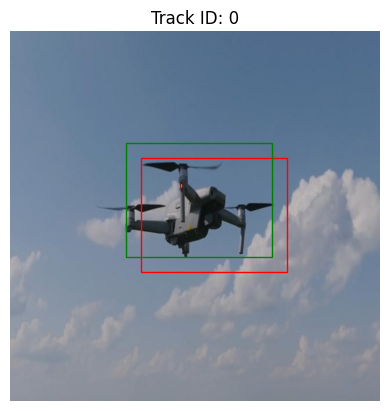

0


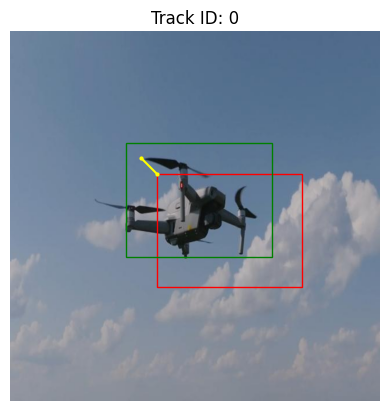

1


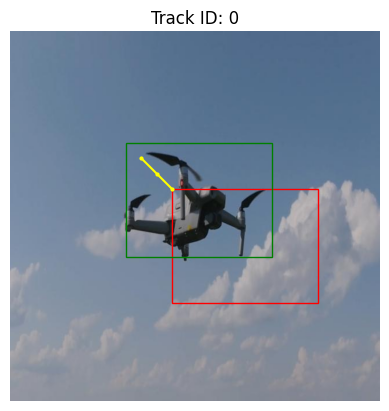

2


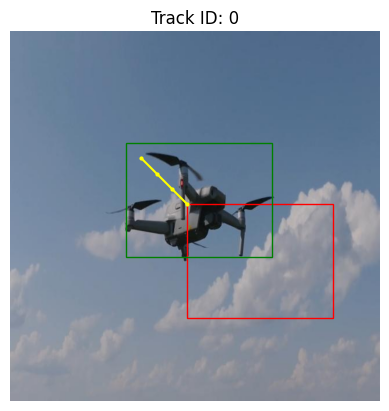

3


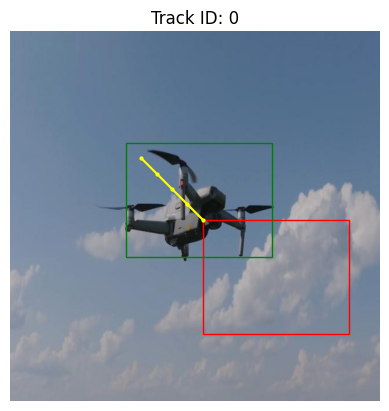

4


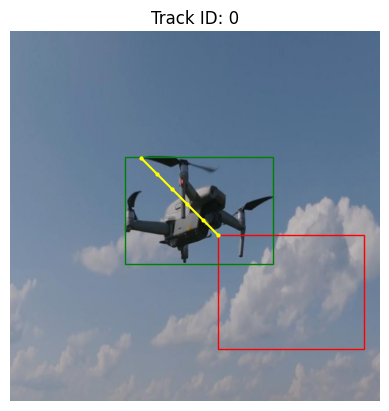

5


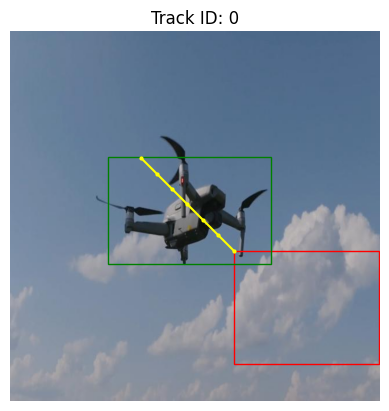

6


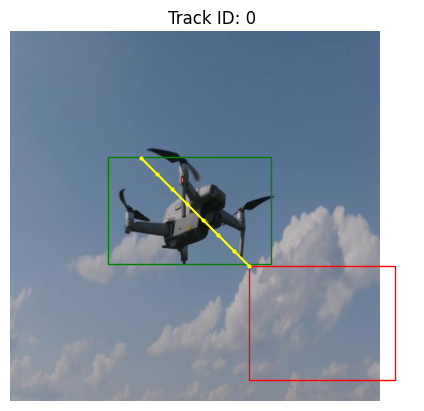

7


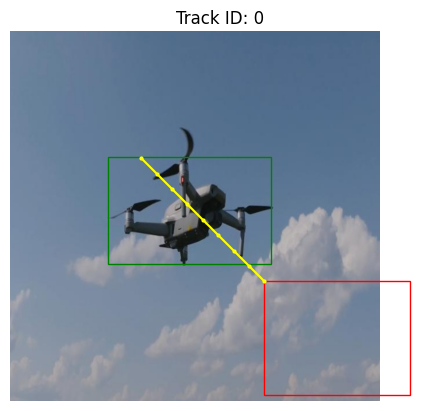

8


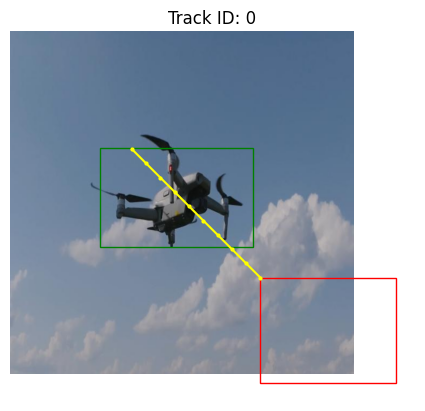

9


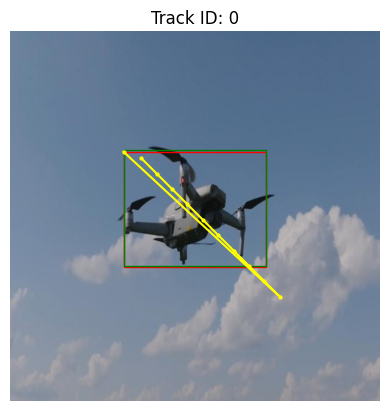

10


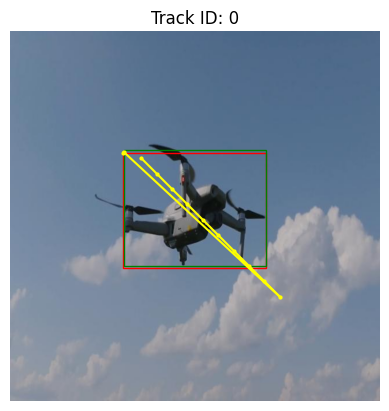

11


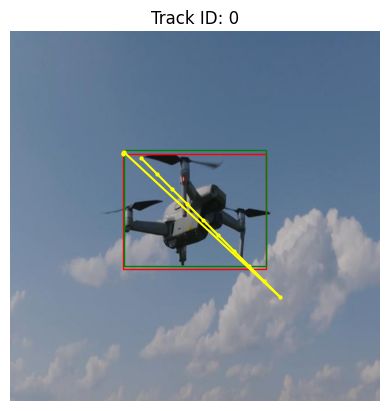

12


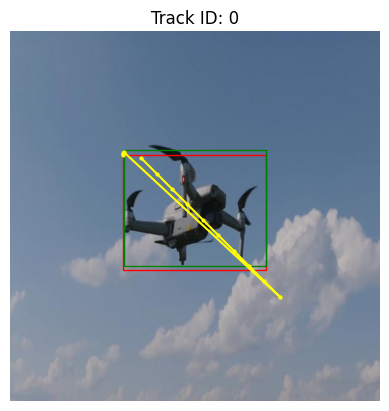

13


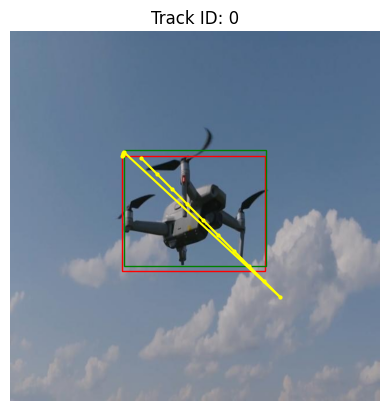

14


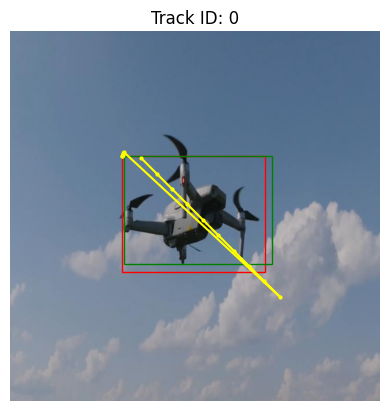

15


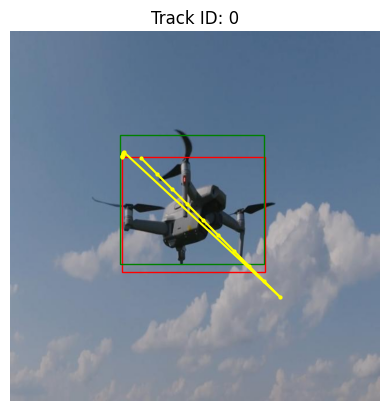

16


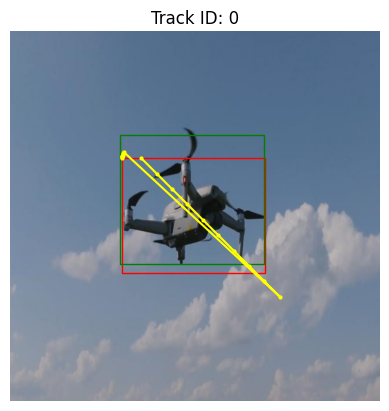

17


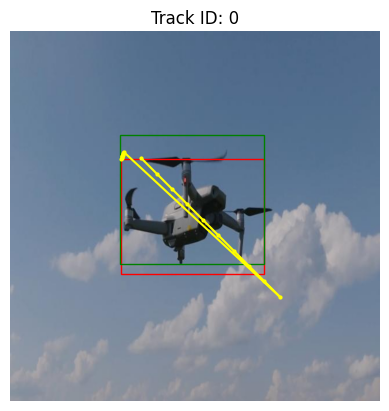

18


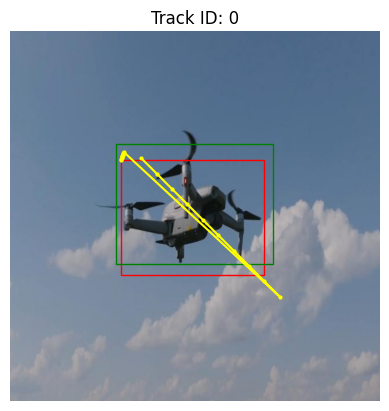

19


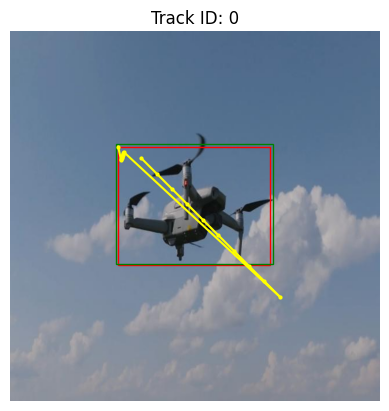

20


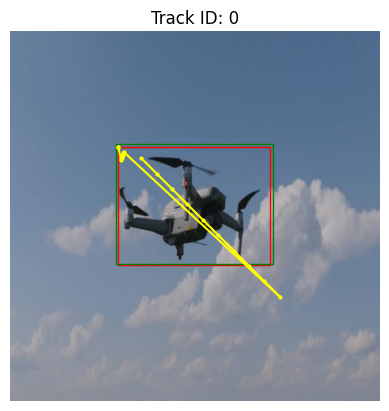

21


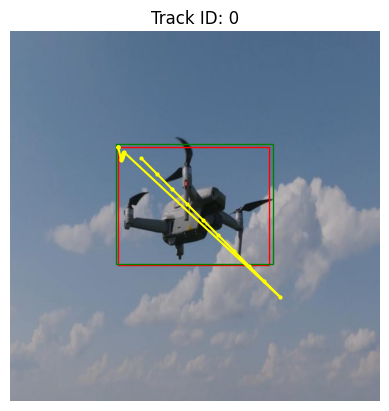

22


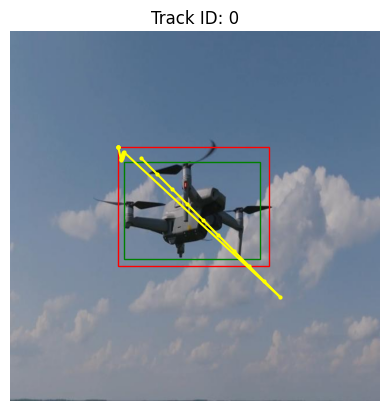

23


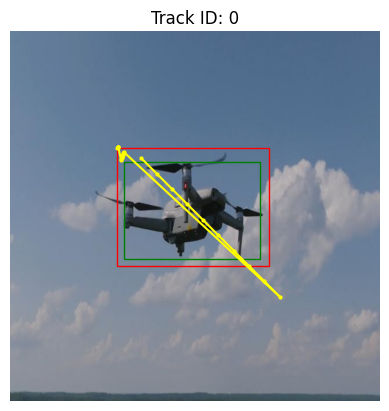

24


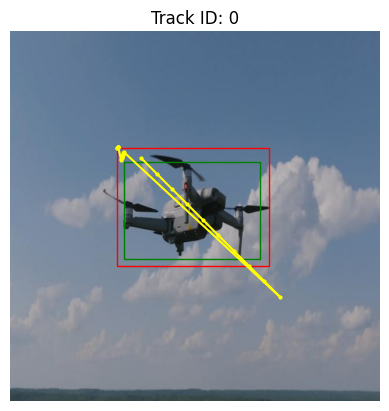

25


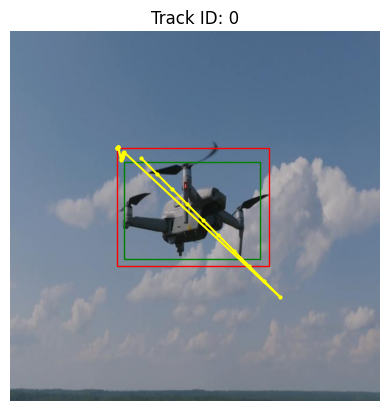

26


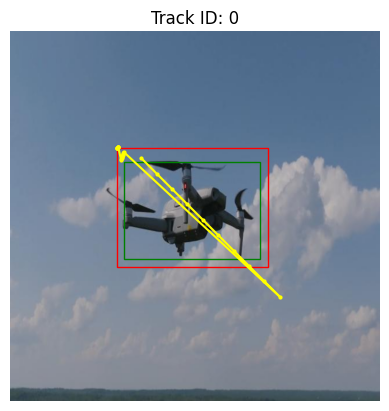

27


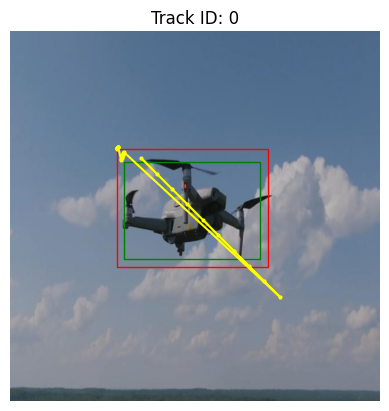

28


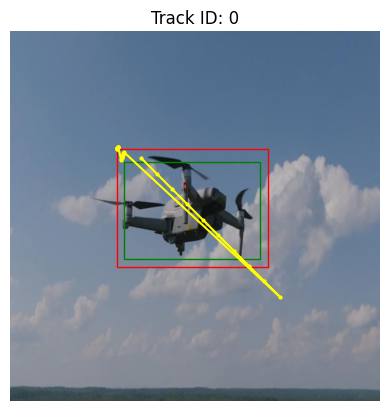

29


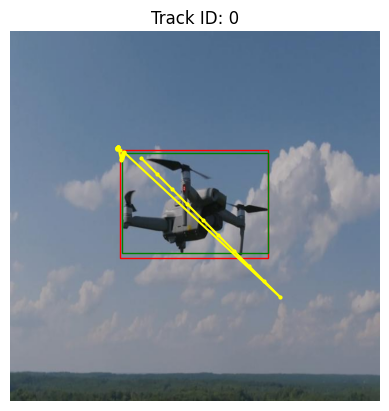

30


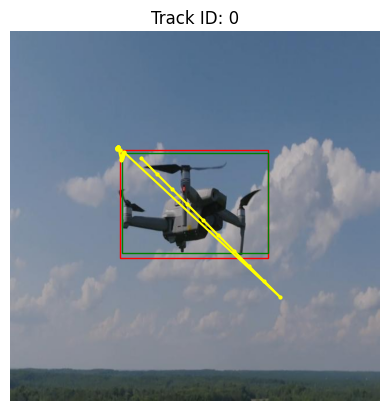

31


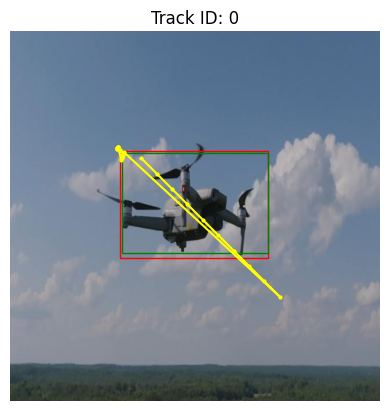

32


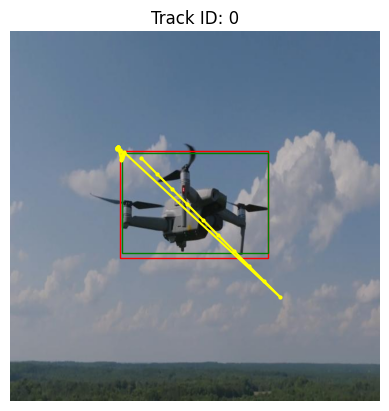

33


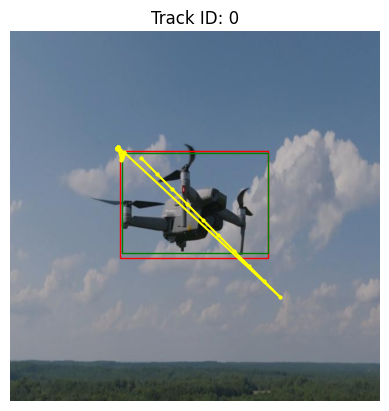

34


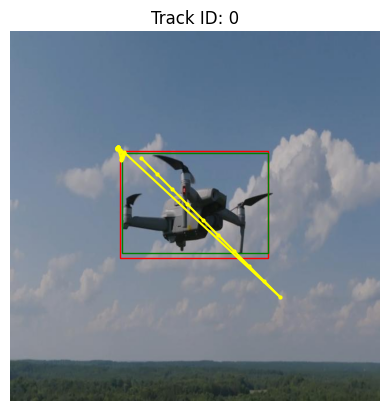

35


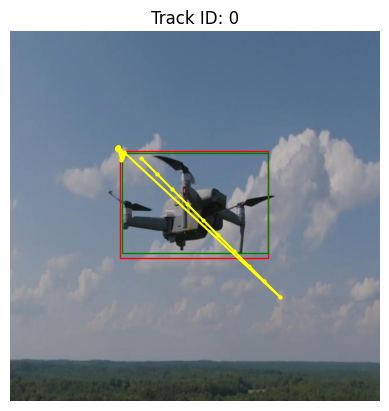

36


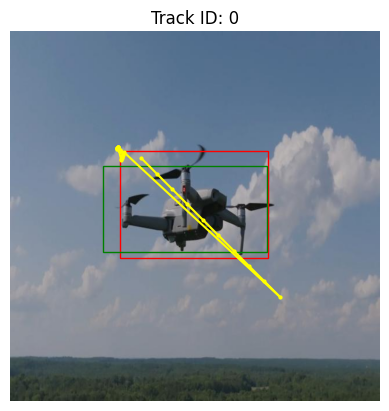

37


In [496]:
for i, frame in frames.iterrows():
    if i % 10 == 0:
        estimate = tracklet.update_and_predict(**frame['bbox_corners'])
    else:
        estimate = tracklet.predict()
    draw_bounding_boxes(tracklet, f"{base_path}/images/{frame['image']}", frame['bbox_corners'])
    print(i)

## Template matching using FLANN and SIFT
Enhanced prediction using handcrafted SIFT features and template matching previous bounding boxes.

In [563]:
def extract_features(image, bbox, feature_extractor):
    """ Extract features from the specified bounding box in the image. """
    img_height, img_width = image.shape[:2]
    
    x1 = int(bbox["x1"] * img_width)
    y1 = int(bbox["y1"] * img_height)
    x2 = int(bbox["x2"] * img_width)
    y2 = int(bbox["y2"] * img_height)
    
    print(x1, x2, y1, y2)
    w = get_width(**bbox)
    h = get_height(**bbox)
    roi = image[y1:y2, x1:x2]
    keypoints, descriptors = feature_extractor.detectAndCompute(roi, None)
    return keypoints, descriptors, roi

In [564]:
def match_features(descriptors1, descriptors2):
    """ Match features using FLANN based matcher. """
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    # Filter matches using the Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)
    return good_matches

In [565]:
def find_bbox_shift(good_matches, keypoints1, keypoints2):
    """ Calculate the shift in bounding box based on matched features. """
    if not good_matches:
        return 0, 0  # No shift if no good matches found

    dxs = []
    dys = []
    for match in good_matches:
        pt1 = keypoints1[match.queryIdx].pt
        pt2 = keypoints2[match.trainIdx].pt
        dxs.append(pt2[0] - pt1[0])
        dys.append(pt2[1] - pt1[1])
    shift_x = np.mean(dxs)
    shift_y = np.mean(dys)
    return int(shift_x), int(shift_y)


In [566]:
sift_extractor = cv2.SIFT_create()

In [567]:
def draw_bounding_boxes(estimate, image_path, original=None):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib

    if image is None:
        print(f"Image not found: {image_path}")
        return

    fig, ax = plt.subplots()
    ax.imshow(image)
    estimate_rect = plt.Rectangle((estimate['x1'] * image.shape[1], estimate['y1'] * image.shape[0]), 
                     get_width(**estimate) * image.shape[1], get_height(**estimate) * image.shape[0],
                     linewidth=1, edgecolor='r', facecolor='none')
    if original:
        original_rect = plt.Rectangle((original['x1'] * image.shape[1], original['y1'] * image.shape[0]), 
                             get_width(**original) * image.shape[1], get_height(**original) * image.shape[0],
                             linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(estimate_rect)
    ax.add_patch(original_rect)


    # Draw trajectory
    if len(tracklet.positions) > 1:
        x_vals = [pos[0] * image.shape[1] for pos in tracklet.positions]
        y_vals = [pos[1] * image.shape[0] for pos in tracklet.positions]
        ax.plot(x_vals, y_vals, marker='o', markersize=2, linestyle='-', color='yellow')

    ax.set_title(f"Track ID: {tracklet.track_id}")
    ax.axis('off')  # Turn off axis numbers and ticks
    plt.show()

200 453 192 389
200 453 192 389
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.3130208328125, 'y1': 0.30092592656249995, 'x2': 0.7078125, 'y2': 0.609259259375}


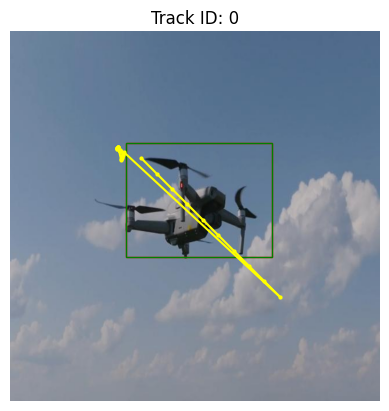

1
200 453 192 389
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.3130208328125, 'y1': 0.30092592656249995, 'x2': 0.7078125, 'y2': 0.609259259375}


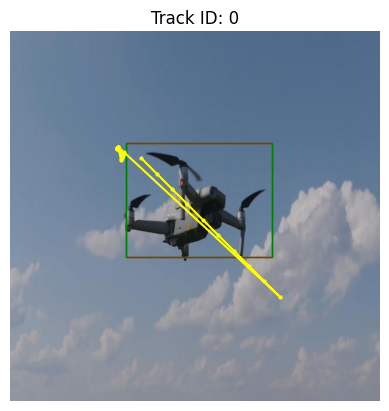

2
200 453 192 389
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.3130208328125, 'y1': 0.30092592656249995, 'x2': 0.7078125, 'y2': 0.609259259375}


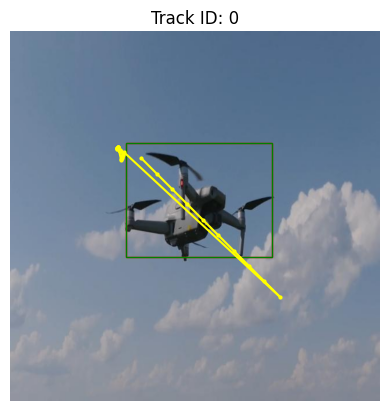

3
200 453 192 389
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.3130208328125, 'y1': 0.30092592656249995, 'x2': 0.7078125, 'y2': 0.609259259375}


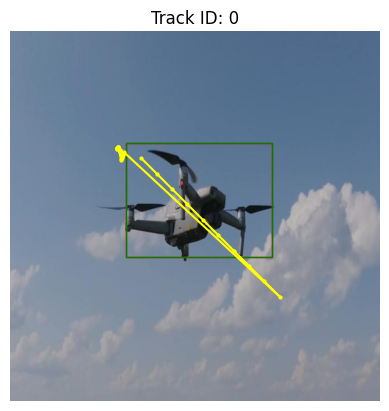

4
198 455 217 401
0.0015625 -0.0375
Suggested bounding box shift: 1 px in x direction, -24 px in y direction
{'x1': 0.31145833281249996, 'y1': 0.30231481406250005, 'x2': 0.7125, 'y2': 0.590277778125}


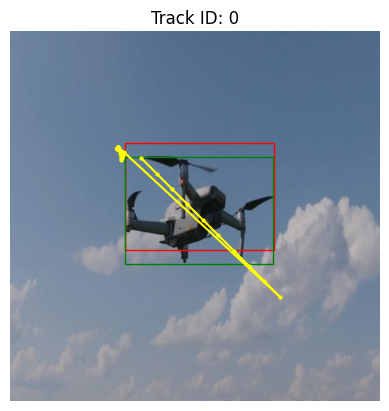

5
168 452 216 402
0.05 -0.0359375
Suggested bounding box shift: 32 px in x direction, -23 px in y direction
{'x1': 0.3130208328125, 'y1': 0.3029513890625, 'x2': 0.7562500000000001, 'y2': 0.5927662031250001}


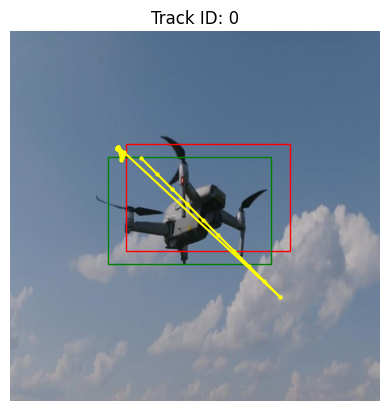

6
168 452 216 402
0.05 -0.0359375
Suggested bounding box shift: 32 px in x direction, -23 px in y direction
{'x1': 0.3130208328125, 'y1': 0.3029513890625, 'x2': 0.7562500000000001, 'y2': 0.5927662031250001}


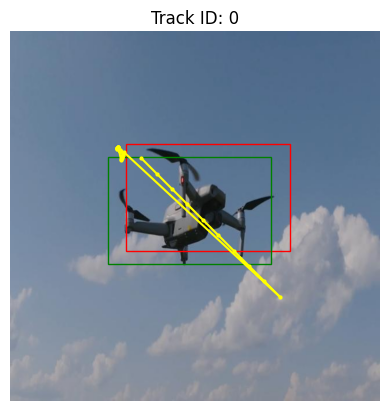

7
168 452 216 402
0.05 -0.0359375
Suggested bounding box shift: 32 px in x direction, -23 px in y direction
{'x1': 0.3130208328125, 'y1': 0.3029513890625, 'x2': 0.7562500000000001, 'y2': 0.5927662031250001}


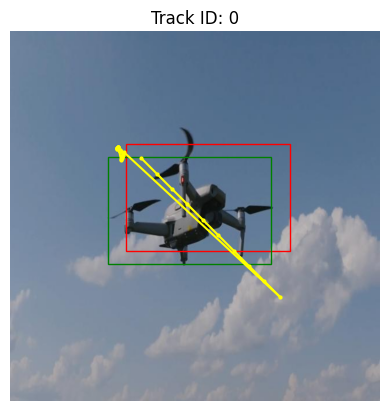

8
168 452 216 402
0.05 -0.0359375
Suggested bounding box shift: 32 px in x direction, -23 px in y direction
{'x1': 0.3130208328125, 'y1': 0.3029513890625, 'x2': 0.7562500000000001, 'y2': 0.5927662031250001}


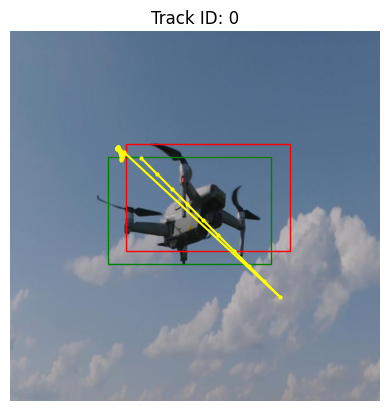

9
197 442 205 405
197 442 205 405
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.3078125, 'y1': 0.32037037031250004, 'x2': 0.690625, 'y2': 0.6333333328124999}


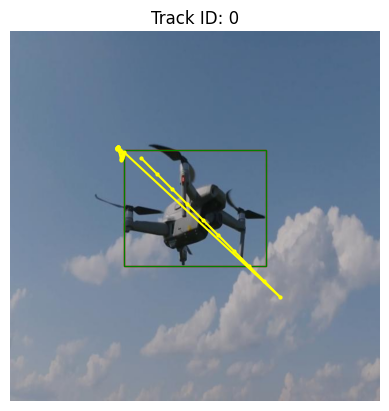

11
197 442 205 405
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.3078125, 'y1': 0.32037037031250004, 'x2': 0.690625, 'y2': 0.6333333328124999}


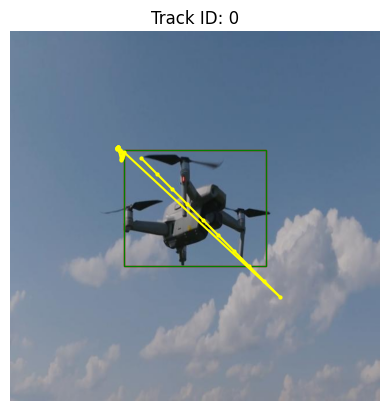

12
197 442 205 405
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.3078125, 'y1': 0.32037037031250004, 'x2': 0.690625, 'y2': 0.6333333328124999}


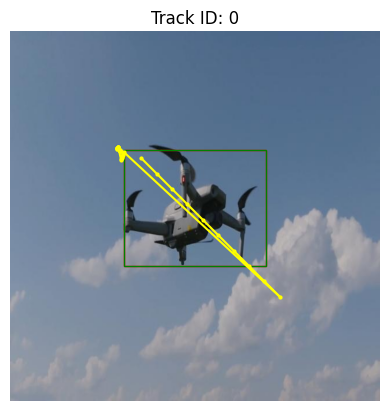

13
197 442 205 405
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.3078125, 'y1': 0.32037037031250004, 'x2': 0.690625, 'y2': 0.6333333328124999}


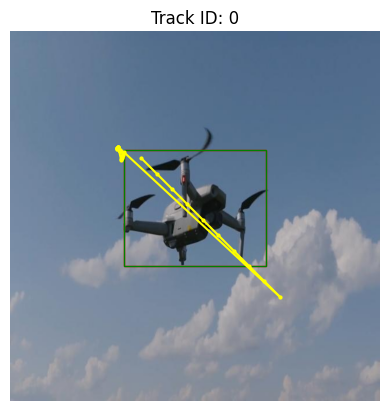

14
196 453 215 402
0.0015625 -0.015625
Suggested bounding box shift: 1 px in x direction, -10 px in y direction
{'x1': 0.30833333281249997, 'y1': 0.3204861109375, 'x2': 0.7098958328125, 'y2': 0.6140046296875}


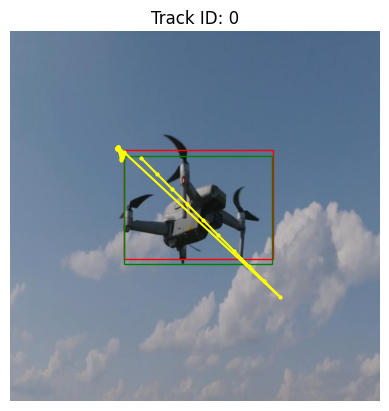

15
190 440 179 401
0.009375 0.0390625
Suggested bounding box shift: 6 px in x direction, 25 px in y direction
{'x1': 0.3072916671875, 'y1': 0.31961805624999995, 'x2': 0.696875, 'y2': 0.666840278125}


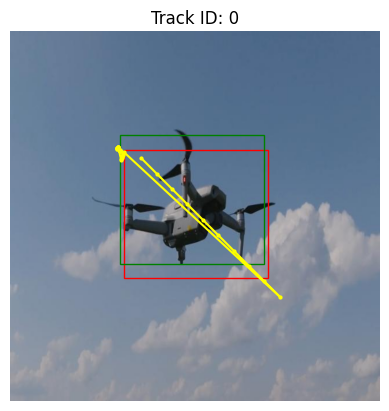

16
190 440 179 401
0.009375 0.0390625
Suggested bounding box shift: 6 px in x direction, 25 px in y direction
{'x1': 0.3072916671875, 'y1': 0.31961805624999995, 'x2': 0.696875, 'y2': 0.666840278125}


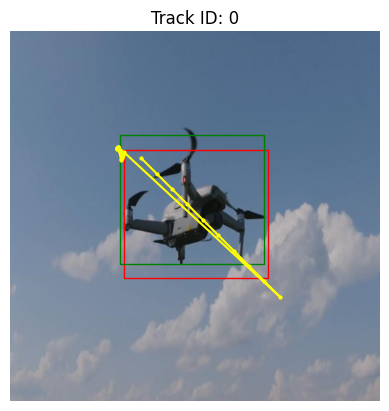

17
190 440 179 401
0.009375 0.0390625
Suggested bounding box shift: 6 px in x direction, 25 px in y direction
{'x1': 0.3072916671875, 'y1': 0.31961805624999995, 'x2': 0.696875, 'y2': 0.666840278125}


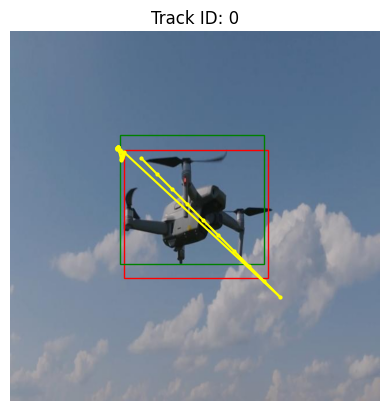

18
182 454 194 402
0.0234375 0.015625
Suggested bounding box shift: 15 px in x direction, 10 px in y direction
{'x1': 0.30937499999999996, 'y1': 0.31932870312499995, 'x2': 0.7333333328125, 'y2': 0.644328703125}


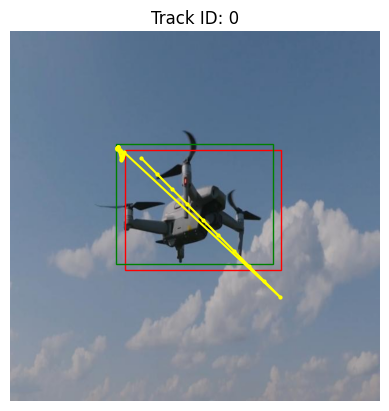

19
182 454 194 402
182 454 194 402
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.28593749999999996, 'y1': 0.30370370312499995, 'x2': 0.7098958328125, 'y2': 0.628703703125}


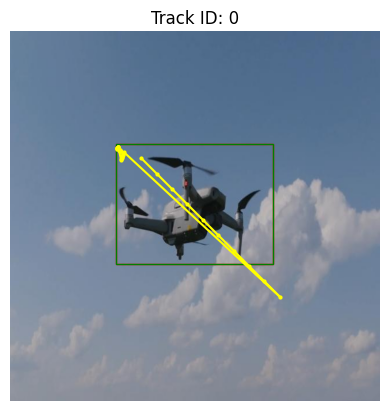

21
182 454 194 402
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.28593749999999996, 'y1': 0.30370370312499995, 'x2': 0.7098958328125, 'y2': 0.628703703125}


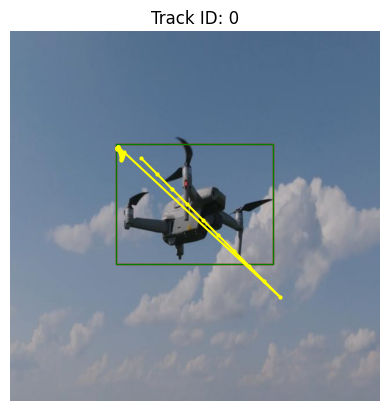

22
197 433 225 394
-0.021875 -0.0484375
Suggested bounding box shift: -14 px in x direction, -31 px in y direction
{'x1': 0.28697916718750005, 'y1': 0.30341435156249996, 'x2': 0.6546875, 'y2': 0.5673032406249998}


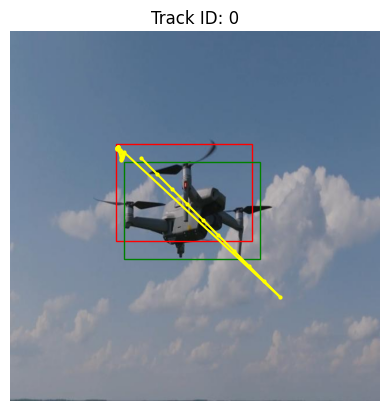

23
197 433 225 394
-0.021875 -0.0484375
Suggested bounding box shift: -14 px in x direction, -31 px in y direction
{'x1': 0.28697916718750005, 'y1': 0.30341435156249996, 'x2': 0.6546875, 'y2': 0.5673032406249998}


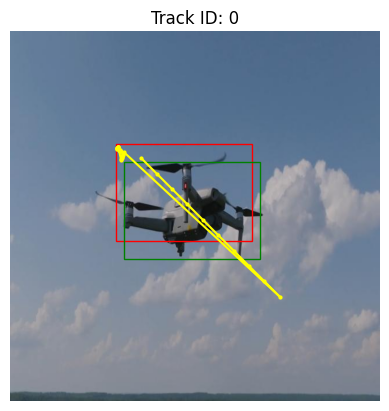

24
197 433 225 394
-0.021875 -0.0484375
Suggested bounding box shift: -14 px in x direction, -31 px in y direction
{'x1': 0.28697916718750005, 'y1': 0.30341435156249996, 'x2': 0.6546875, 'y2': 0.5673032406249998}


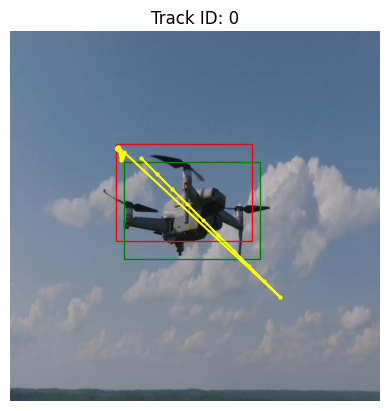

25
197 433 225 394
-0.021875 -0.0484375
Suggested bounding box shift: -14 px in x direction, -31 px in y direction
{'x1': 0.28697916718750005, 'y1': 0.30341435156249996, 'x2': 0.6546875, 'y2': 0.5673032406249998}


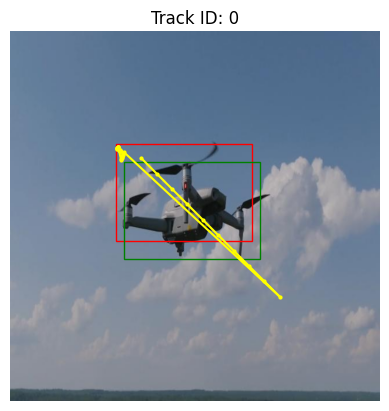

26
197 433 225 394
-0.021875 -0.0484375
Suggested bounding box shift: -14 px in x direction, -31 px in y direction
{'x1': 0.28697916718750005, 'y1': 0.30341435156249996, 'x2': 0.6546875, 'y2': 0.5673032406249998}


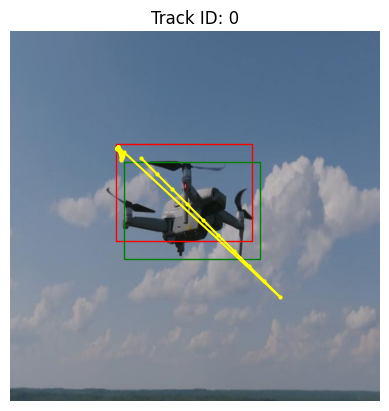

27
197 433 225 394
-0.021875 -0.0484375
Suggested bounding box shift: -14 px in x direction, -31 px in y direction
{'x1': 0.28697916718750005, 'y1': 0.30341435156249996, 'x2': 0.6546875, 'y2': 0.5673032406249998}


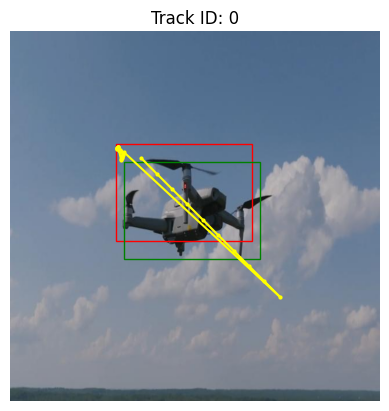

28
197 433 225 394
-0.021875 -0.0484375
Suggested bounding box shift: -14 px in x direction, -31 px in y direction
{'x1': 0.28697916718750005, 'y1': 0.30341435156249996, 'x2': 0.6546875, 'y2': 0.5673032406249998}


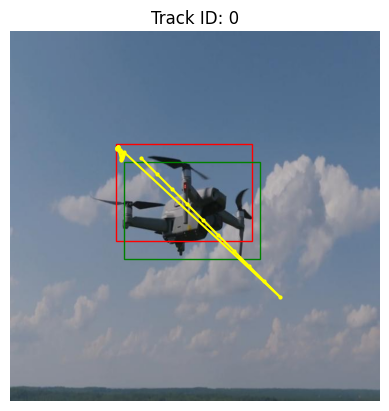

29
193 446 209 383
193 446 209 383
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.30260416718749994, 'y1': 0.32777777812500003, 'x2': 0.696875, 'y2': 0.5999999999999999}


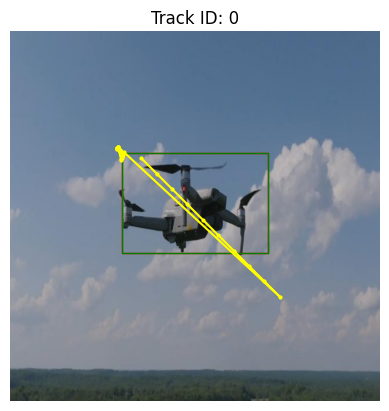

31
193 446 209 383
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.30260416718749994, 'y1': 0.32777777812500003, 'x2': 0.696875, 'y2': 0.5999999999999999}


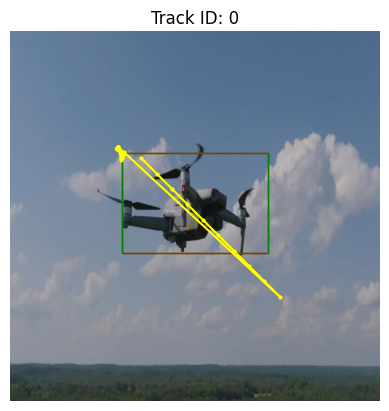

32
193 446 209 383
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.30260416718749994, 'y1': 0.32777777812500003, 'x2': 0.696875, 'y2': 0.5999999999999999}


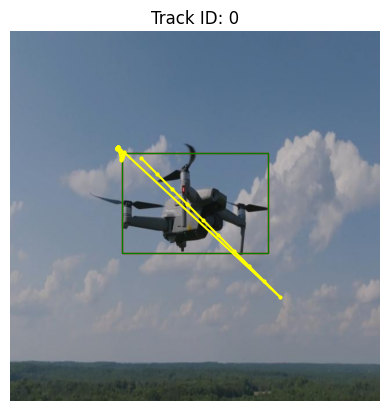

33
193 446 209 383
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.30260416718749994, 'y1': 0.32777777812500003, 'x2': 0.696875, 'y2': 0.5999999999999999}


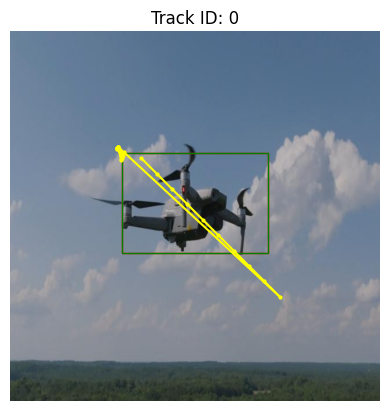

34
193 446 209 383
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.30260416718749994, 'y1': 0.32777777812500003, 'x2': 0.696875, 'y2': 0.5999999999999999}


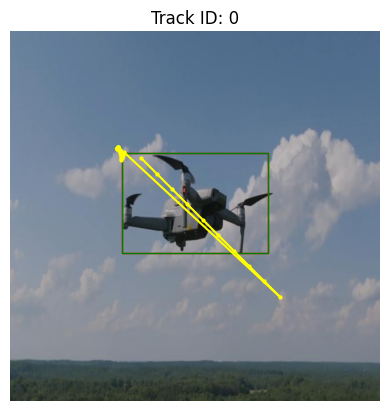

35
193 446 209 383
0.0 0.0
Suggested bounding box shift: 0 px in x direction, 0 px in y direction
{'x1': 0.30260416718749994, 'y1': 0.32777777812500003, 'x2': 0.696875, 'y2': 0.5999999999999999}


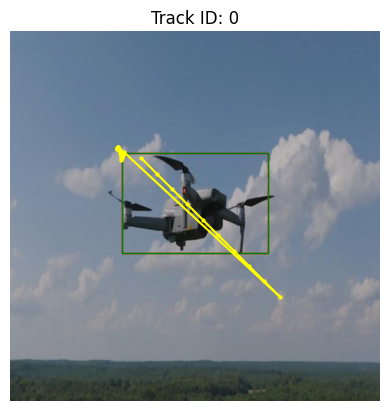

36
159 444 232 381
0.0515625 -0.0359375
Suggested bounding box shift: 33 px in x direction, -23 px in y direction
{'x1': 0.30156249999999996, 'y1': 0.3279513890625, 'x2': 0.7463541671875, 'y2': 0.560358796875}


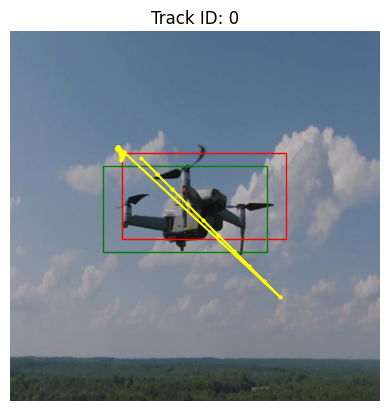

37


In [578]:
for i, frame in frames.iterrows():
    if i % 10 == 0:
        base_frame_img = cv2.imread(f"{base_path}/images/{frame['image']}")
        base_keypoints, base_descriptors, _ = extract_features(base_frame_img, frame['bbox_corners'], sift_extractor)
        #estimate = tracklet.update_and_predict(**frame['bbox_corners'])
    else:
        #estimate = tracklet.predict()
        frame_img = cv2.imread(f"{base_path}/images/{frame['image']}")
        frame_keypoints, frame_descriptors, _ = extract_features(base_frame_img, frame['bbox_corners'], sift_extractor)
        good_matches = match_features(base_descriptors, frame_descriptors)
        shift_x, shift_y = find_bbox_shift(good_matches, base_keypoints, frame_keypoints)
        # Find bounding box shift
        shift_frac_x = shift_x / base_frame_img.shape[0]
        shift_frac_y = shift_y / base_frame_img.shape[1]
        print(f"Suggested bounding box shift: {shift_x} px in x direction, {shift_y} px in y direction")
        print(f"In fraction: x: {shift_frac_x}, y: {shift_frac_y}")

        estimate = {"x1": frame['bbox_corners']["x1"] + shift_frac_x, "y1":  frame['bbox_corners']["y1"] + shift_frac_y, 
                    "x2":  frame['bbox_corners']["x2"] + shift_frac_x, "y2":  frame['bbox_corners']["y2"] + shift_frac_y}
        print(estimate)
        draw_bounding_boxes(estimate, f"{base_path}/images/{frame['image']}", frame['bbox_corners'])
        print(i)

In [577]:



# Match features


